In [1]:
import os.path as op
import tempfile

import matplotlib.pyplot as plt


import hnn_core
from hnn_core import simulate_dipole, jones_2009_model
from hnn_core.viz import plot_dipole

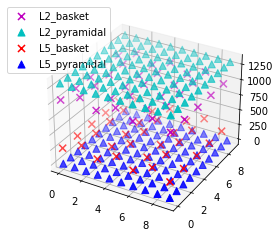

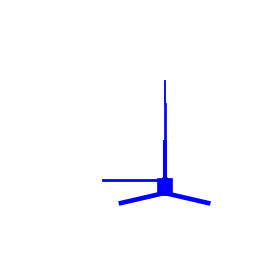

<Axes3DSubplot:>

In [2]:
net = jones_2009_model()
net.plot_cells()
net.cell_types['L5_pyramidal'].plot_morphology()

In [3]:
weights_ampa_d1 = {'L2_basket': 0.006562, 'L2_pyramidal': .000007,
                   'L5_pyramidal': 0.142300}
weights_nmda_d1 = {'L2_basket': 0.019482, 'L2_pyramidal': 0.004317,
                   'L5_pyramidal': 0.080074}
synaptic_delays_d1 = {'L2_basket': 0.1, 'L2_pyramidal': 0.1,
                      'L5_pyramidal': 0.1}
net.add_evoked_drive(
    'evdist1', mu=63.53, sigma=3.85, numspikes=1, weights_ampa=weights_ampa_d1,
    weights_nmda=weights_nmda_d1, location='distal',
    synaptic_delays=synaptic_delays_d1, event_seed=4)

In [4]:
weights_ampa_p1 = {'L2_basket': 0.08831, 'L2_pyramidal': 0.01525,
                   'L5_basket': 0.19934, 'L5_pyramidal': 0.00865}
synaptic_delays_prox = {'L2_basket': 0.1, 'L2_pyramidal': 0.1,
                        'L5_basket': 1., 'L5_pyramidal': 1.}
# all NMDA weights are zero; pass None explicitly
net.add_evoked_drive(
    'evprox1', mu=26.61, sigma=2.47, numspikes=1, weights_ampa=weights_ampa_p1,
    weights_nmda=None, location='proximal',
    synaptic_delays=synaptic_delays_prox, event_seed=4)

# Second proximal evoked drive. NB: only AMPA weights differ from first
weights_ampa_p2 = {'L2_basket': 0.000003, 'L2_pyramidal': 1.438840,
                   'L5_basket': 0.008958, 'L5_pyramidal': 0.684013}
# all NMDA weights are zero; omit weights_nmda (defaults to None)
net.add_evoked_drive(
    'evprox2', mu=137.12, sigma=8.33, numspikes=1,
    weights_ampa=weights_ampa_p2, location='proximal',
    synaptic_delays=synaptic_delays_prox, event_seed=4)

In [5]:
from hnn_core import JoblibBackend

with JoblibBackend(n_jobs=4):
    dpls = simulate_dipole(net, dt=0.4, tstop=170., n_trials=4)     ### dt ist the time resolution; default: dt=0.025

joblib will run over 4 jobs
Loading custom mechanism files from /home/kathi/anaconda3/envs/sbi_env/lib/python3.7/site-packages/hnn_core/mod/x86_64/.libs/libnrnmech.so
Building the NEURON model
Loading custom mechanism files from /home/kathi/anaconda3/envs/sbi_env/lib/python3.7/site-packages/hnn_core/mod/x86_64/.libs/libnrnmech.so
Building the NEURON model
Loading custom mechanism files from /home/kathi/anaconda3/envs/sbi_env/lib/python3.7/site-packages/hnn_core/mod/x86_64/.libs/libnrnmech.so
Building the NEURON model
Loading custom mechanism files from /home/kathi/anaconda3/envs/sbi_env/lib/python3.7/site-packages/hnn_core/mod/x86_64/.libs/libnrnmech.so
Building the NEURON model
[Done]
running trial 1 on 1 cores
Simulation time: 0.4 ms...
[Done]
running trial 2 on 1 cores
Simulation time: 10.0 ms...
[Done]
[Done]
running trial 4 on 1 cores
running trial 3 on 1 cores
Simulation time: 0.4 ms...
Simulation time: 0.4 ms...
Simulation time: 0.4 ms...
Simulation time: 20.0 ms...
Simulation t

In [6]:
window_len, scaling_factor = 30, 3000
for dpl in dpls:
    dpl.smooth(window_len).scale(scaling_factor)

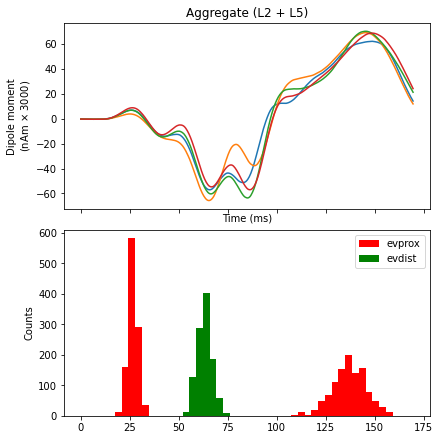

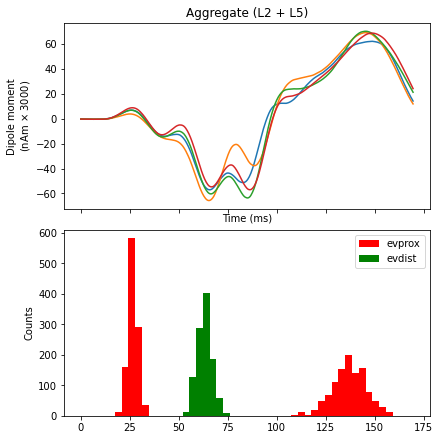

In [7]:
import matplotlib.pyplot as plt
fig, axes = plt.subplots(2, 1, sharex=True, figsize=(6, 6),
                         constrained_layout=True)
plot_dipole(dpls, ax=axes[0], layer='agg', show=False)
net.cell_response.plot_spikes_hist(ax=axes[1],
                                   spike_types=['evprox', 'evdist'])

In [8]:
### having to think about reasonable summary statistics now


####
#1.) mode
#2.) max time
#3.) min time
#4.) max (or better amplitude?)
#5.) min

## sbi analysis comes in: 

import numpy as np
import torch

# visualization
import matplotlib as mpl
import matplotlib.pyplot as plt

# sbi
from sbi import utils as utils
from sbi import analysis as analysis
from sbi.inference.base import infer

agg
L2
L5
agg
L2
L5
agg
L2
L5
agg
L2
L5


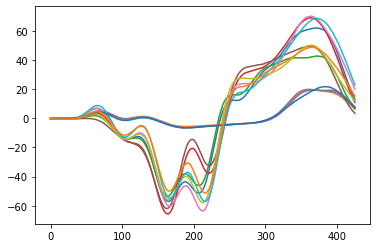

In [9]:
##where are these 6 simulations come from? 
## answer: for both trails, we get data for agg, L2 and L5!

for dpl in dpls:
    for key in dpl.data.keys():
        print(key)
        plt.plot(dpl.data[key])


In [10]:
def syn_current(duration=120, dt=0.01, t_on=10, curr_level=5e-4, seed=None):
    duration = duration
    t_off = duration - t_on
    t = np.arange(0, duration + dt, dt)

    # external current
    A_soma = np.pi * ((70.0 * 1e-4) ** 2)  # cm2
    I = np.zeros_like(t)
    I[int(np.round(t_on / dt)) : int(np.round(t_off / dt))] = (
        curr_level / A_soma
    )  # muA/cm2

    return I, t_on, t_off, dt, t, A_soma

In [11]:
from scipy import stats as spstats

def calculate_summary_statistics(x):
    """Calculate summary statistics
    Parameters
    ----------
    x : output of the simulator
    Returns
    -------
    np.array, summary statistics
    """
    I, t_on, t_off, dt, t, A_soma = syn_current()

    n_mom = 4
    n_summary = 7

    n_summary = np.minimum(n_summary, n_mom + 3)

    t = x["time"]
    dt = x["dt"]

    # initialise array of spike counts
    v = np.array(x["data"])

    # put everything to -10 that is below -10 or has negative slope
    ind = np.where(v < -10)
    v[ind] = -10
    ind = np.where(np.diff(v) < 0)
    v[ind] = -10

    # remaining negative slopes are at spike peaks
    ind = np.where(np.diff(v) < 0)
    spike_times = np.array(t)[ind]
    spike_times_stim = spike_times[(spike_times > t_on) & (spike_times < t_off)]

    # number of spikes
    if spike_times_stim.shape[0] > 0:
        spike_times_stim = spike_times_stim[
            np.append(1, np.diff(spike_times_stim)) > 0.5
        ]

    # resting potential and std
    rest_pot = np.mean(x["data"][t < t_on])
    rest_pot_std = np.std(x["data"][int(0.9 * t_on / dt) : int(t_on / dt)])

    # moments
    std_pw = np.power(
        np.std(x["data"][(t > t_on) & (t < t_off)]), np.linspace(3, n_mom, n_mom - 2)
    )
    std_pw = np.concatenate((np.ones(1), std_pw))
    moments = (
        spstats.moment(
            x["data"][(t > t_on) & (t < t_off)], np.linspace(2, n_mom, n_mom - 1)
        )
        / std_pw
    )

    # concatenation of summary statistics
    sum_stats_vec = np.concatenate(
        (
            np.array([spike_times_stim.shape[0]]),
            np.array(
                [rest_pot, rest_pot_std, np.mean(x["data"][(t > t_on) & (t < t_off)])]
            ),
            moments,
        )
    )
    sum_stats_vec = sum_stats_vec[0:n_summary]

    return sum_stats_vec

In [12]:

from scipy.stats import moment
from scipy.signal import argrelextrema

def calculate_summary_stats2(x):
    obs_max = torch.max(x)
    obs_min = torch.min(x)

    time1 = torch.argmax(x)
    time2 = torch.argmin(x)

    diff_min_max = torch.abs(torch.subtract(obs_max,obs_min))

    #second_moment = moment(x, moment=2)


    ### catch also local minima, maxima?

    
    # for local maxima
    #local_max = argrelextrema(x.cpu().detach().numpy(), np.greater)

    # for local minima
    #local_min = argrelextrema(x.cpu().detach().numpy(), np.less)

    sum_stats_vec = torch.Tensor([obs_max, 
            obs_min,
            #second_moment,
            diff_min_max,
            time1,
            time2,
            #local_min,
            #torch.Tensor(local_max)
            ]
        )
    return sum_stats_vec   


In [13]:
a = torch.max(torch.Tensor([1,2,3]))
b = torch.max(torch.Tensor([2,3,4]))

torch.Tensor([a,b])

tensor([3., 4.])

In [14]:

from hnn_core import JoblibBackend



def simulation_wrapper(params):   #input possibly array of 1 or more params
    """
    Returns summary statistics from conductance values in `params`.

    Summarizes the output of the HH simulator and converts it to `torch.Tensor`.
    """
    #'L2_pyramidal', 't_stop'
    #writing params as dict?
    net._params['t_evdist_1'] = params[0]
    net._params['sigma_t_evdist_1'] = params[1]
    net._params['t_evprox_2'] = params[2]
    net._params['sigma_t_evprox_2'] = params[3]

    ##simulates 8 trials at a time like this
    dpls = simulate_dipole(net, tstop=170., n_trials=8)
    for dpl in dpls:
        obs = dpl.data['agg']

    #left out summary statistics for a start
    sum_stats = calculate_summary_stats2(torch.from_numpy(obs))
    return sum_stats



In [15]:
### extracting parameters
## not only values, but categories! How to deal with them?



#net.external_drives['evdist1']

#print(net._params.items())
## prior which parameters? --> all that go into simulator???
## evoked primal/distal...
## can I set 'None' to all the parameters I am not interested on? Maybe I only want to infer 3.. 



prior_min = [51.0, 1.9, 112, 4.2]    # 't_evdist_1', 'sigma_t_evdist_1', 't_evprox_2', 'sigma_t_evprox_2'

prior_max = [75.0, 5.8, 162, 12.5]     

prior = utils.torchutils.BoxUniform(low=prior_min, 
                                    high=prior_max)


dict_items([('sim_prefix', 'default'), ('tstop', 170), ('N_pyr_x', 10), ('N_pyr_y', 10), ('L2Basket_Gauss_A_weight', 0.0), ('L2Basket_Gauss_mu', 2000.0), ('L2Basket_Gauss_sigma', 3.6), ('L2Basket_Pois_A_weight_ampa', 0.0), ('L2Basket_Pois_A_weight_nmda', 0.0), ('L2Basket_Pois_lamtha', 0.0), ('L2Pyr_Gauss_A_weight', 0.0), ('L2Pyr_Gauss_mu', 2000.0), ('L2Pyr_Gauss_sigma', 3.6), ('L2Pyr_Pois_A_weight_ampa', 0.0), ('L2Pyr_Pois_A_weight_nmda', 0.0), ('L2Pyr_Pois_lamtha', 0.0), ('L5Pyr_Gauss_A_weight', 0.0), ('L5Pyr_Gauss_mu', 2000.0), ('L5Pyr_Gauss_sigma', 4.8), ('L5Pyr_Pois_A_weight_ampa', 0.0), ('L5Pyr_Pois_A_weight_nmda', 0.0), ('L5Pyr_Pois_lamtha', 0.0), ('L5Basket_Gauss_A_weight', 0.0), ('L5Basket_Gauss_mu', 2000.0), ('L5Basket_Gauss_sigma', 2.0), ('L5Basket_Pois_A_weight_ampa', 0.0), ('L5Basket_Pois_A_weight_nmda', 0.0), ('L5Basket_Pois_lamtha', 0.0), ('gbar_L2Pyr_L2Pyr_ampa', 0.0005), ('gbar_L2Pyr_L2Pyr_nmda', 0.0005), ('gbar_L2Basket_L2Pyr_gabaa', 0.05), ('gbar_L2Basket_L2Pyr_gabab'

In [18]:
posterior = infer(simulation_wrapper, prior, method='SNPE_C', 
                  num_simulations=1, num_workers=1)     

joblib will run over 1 jobs
Building the NEURON model
[Done]
running trial 1 on 1 cores
Simulation time: 0.03 ms...
Simulation time: 10.0 ms...
Simulation time: 20.0 ms...
Simulation time: 30.0 ms...
Simulation time: 40.0 ms...
Simulation time: 50.0 ms...
Simulation time: 60.0 ms...
Simulation time: 70.0 ms...
Simulation time: 80.0 ms...
Simulation time: 90.0 ms...
Simulation time: 100.0 ms...
Simulation time: 110.0 ms...
Simulation time: 120.0 ms...
Simulation time: 130.0 ms...
Simulation time: 140.0 ms...
Simulation time: 150.0 ms...
Simulation time: 160.0 ms...
Building the NEURON model
[Done]
running trial 2 on 1 cores
Simulation time: 0.03 ms...
Simulation time: 10.0 ms...
Simulation time: 20.0 ms...
Simulation time: 30.0 ms...
Simulation time: 40.0 ms...
Simulation time: 50.0 ms...
Simulation time: 60.0 ms...
Simulation time: 70.0 ms...
Simulation time: 80.0 ms...
Simulation time: 90.0 ms...
Simulation time: 100.0 ms...
Simulation time: 110.0 ms...
Simulation time: 120.0 ms...
Si

Running 8 simulations in 8 batches.:   0%|          | 0/8 [00:00<?, ?it/s]

joblib will run over 1 jobs
joblib will run over 1 jobs
joblib will run over 1 jobs
joblib will run over 1 jobs
joblib will run over 1 jobs
joblib will run over 1 jobs
joblib will run over 1 jobs
joblib will run over 1 jobs
Loading custom mechanism files from /home/kathi/anaconda3/envs/sbi_env/lib/python3.7/site-packages/hnn_core/mod/x86_64/.libs/libnrnmech.so
Building the NEURON model
Loading custom mechanism files from /home/kathi/anaconda3/envs/sbi_env/lib/python3.7/site-packages/hnn_core/mod/x86_64/.libs/libnrnmech.so
Building the NEURON model
Loading custom mechanism files from /home/kathi/anaconda3/envs/sbi_env/lib/python3.7/site-packages/hnn_core/mod/x86_64/.libs/libnrnmech.so
Building the NEURON model
Loading custom mechanism files from /home/kathi/anaconda3/envs/sbi_env/lib/python3.7/site-packages/hnn_core/mod/x86_64/.libs/libnrnmech.so
Building the NEURON model
Loading custom mechanism files from /home/kathi/anaconda3/envs/sbi_env/lib/python3.7/site-packages/hnn_core/mod/x86_

Running 8 simulations in 8 batches.:  12%|█▎        | 1/8 [48:54<5:42:19, 2934.21s/it]

Simulation time: 90.0 ms...
Simulation time: 90.0 ms...
Simulation time: 90.0 ms...
Simulation time: 90.0 ms...
Simulation time: 160.0 ms...
Simulation time: 100.0 ms...
Simulation time: 100.0 ms...
Simulation time: 100.0 ms...
Simulation time: 100.0 ms...
Simulation time: 100.0 ms...
Simulation time: 100.0 ms...


Running 8 simulations in 8 batches.:  25%|██▌       | 2/8 [49:23<2:02:33, 1225.55s/it]

Simulation time: 110.0 ms...
Simulation time: 110.0 ms...
Simulation time: 110.0 ms...
Simulation time: 110.0 ms...
Simulation time: 110.0 ms...
Simulation time: 110.0 ms...
Simulation time: 120.0 ms...
Simulation time: 120.0 ms...
Simulation time: 120.0 ms...
Simulation time: 130.0 ms...
Simulation time: 120.0 ms...
Simulation time: 120.0 ms...
Simulation time: 130.0 ms...
Simulation time: 120.0 ms...
Simulation time: 140.0 ms...
Simulation time: 140.0 ms...
Simulation time: 130.0 ms...
Simulation time: 130.0 ms...
Simulation time: 130.0 ms...
Simulation time: 130.0 ms...
Simulation time: 150.0 ms...
Simulation time: 150.0 ms...
Simulation time: 140.0 ms...
Simulation time: 140.0 ms...
Simulation time: 160.0 ms...
Simulation time: 140.0 ms...
Simulation time: 140.0 ms...
Simulation time: 150.0 ms...
Simulation time: 160.0 ms...
Simulation time: 150.0 ms...
Simulation time: 150.0 ms...
Simulation time: 150.0 ms...


Running 8 simulations in 8 batches.:  38%|███▊      | 3/8 [50:41<58:27, 701.43s/it]   

Simulation time: 160.0 ms...


Running 8 simulations in 8 batches.:  50%|█████     | 4/8 [50:47<28:27, 426.92s/it]

Simulation time: 160.0 ms...
Simulation time: 160.0 ms...
Simulation time: 160.0 ms...


Running 8 simulations in 8 batches.: 100%|██████████| 8/8 [51:00<00:00, 382.52s/it]


Neural network successfully converged after 40 epochs.


In [ ]:


net._params['t_evdist_1'] = 63.53
net._params['sigma_t_evdist_1'] = 3.85
net._params['t_evdist_2'] = 137.12
net._params['sigma_t_evprox_2'] = 8.33

dpls = simulate_dipole(net, tstop=170., n_trials=1)
for dpl in dpls:
    obs = dpl.data['agg']

obs_real = calculate_summary_stats2(torch.from_numpy(obs))

samples = posterior.sample((10000,), 
                           x=obs_real)

joblib will run over 1 jobs
Loading custom mechanism files from /home/kathi/anaconda3/envs/sbi_env/lib/python3.7/site-packages/hnn_core/mod/x86_64/.libs/libnrnmech.so
Building the NEURON model
[Done]
running trial 1 on 1 cores
Simulation time: 0.03 ms...
Simulation time: 10.0 ms...
Simulation time: 20.0 ms...
Simulation time: 30.0 ms...
Simulation time: 40.0 ms...
Simulation time: 50.0 ms...
Simulation time: 60.0 ms...
Simulation time: 70.0 ms...
Simulation time: 80.0 ms...
Simulation time: 90.0 ms...
Simulation time: 100.0 ms...
Simulation time: 110.0 ms...
Simulation time: 120.0 ms...
Simulation time: 130.0 ms...
Simulation time: 140.0 ms...
Simulation time: 150.0 ms...
Simulation time: 160.0 ms...


NameError: name 'posterior' is not defined

In [ ]:
true_params = torch.Tensor([63.53, 3.85,  137.12, 8.33])



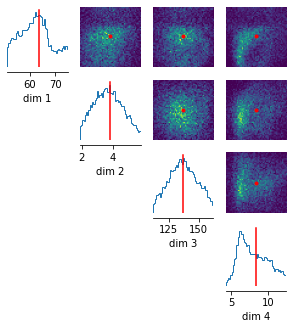

In [ ]:
fig, axes = analysis.pairplot(samples,
                           #limits=[[.5,80], [1e-4,15.]],
                           #ticks=[[.5,80], [1e-4,15.]],
                           figsize=(5,5),
                           points=true_params,
                           points_offdiag={'markersize': 6},
                           points_colors='r');

In [ ]:
fig.savefig('fig2.pdf')